## 1. Problem statement

We want to develop a classifier to detect ASMR from EEG data using topological features, and identify the electrodes with the strongest signal responses.

## 2. Data loading

We will use EEG data from the following study:

Swart, T. (2022, January 11). ASMR amplifies low frequency and reduces high frequency oscillations. Retrieved from osf.io/dg3y5

In [26]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from data import read_raw_data


raw_data = read_raw_data(n_people=1)

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG, 3 misc
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: unspecified
 nchan: 67
 projs: []
 sfreq: 512.0 Hz
>
Using matplotlib as 2D backend.


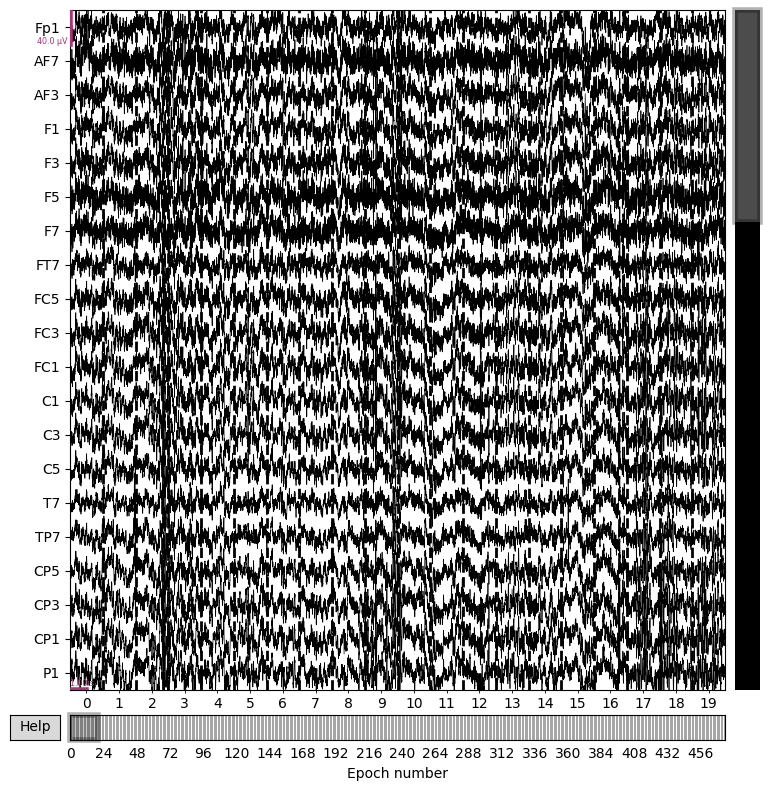

In [3]:
import matplotlib.pyplot as plt


_, raw = raw_data[0]
print(raw.info)
fig = raw.plot(show=False)
plt.show()

## 3. Data processing

The EEG data will undergo the following processing:

1) Segmentation into labeled intervals;
2) Conversion of the time series from each segment and channel into point clouds.

In [4]:
from data import get_processed_data


df = get_processed_data()
df

id                                           interval  \
0      002  [[-1.8779748916625974e-05, -2.0042818069458006...   
1      002  [[1.2216014862060546e-05, 1.1537410736083984e-...   
2      002  [[-3.148919641971588e-07, -3.3316106796264646e...   
3      002  [[-1.1134177207946776e-05, -1.2960216522216797...   
4      002  [[-5.894306659698486e-06, -4.900899887084961e-...   
...    ...                                                ...   
10754  081  [[7.206916332244873e-06, 1.50133216381073e-06,...   
10755  081  [[-7.881077766418457e-06, -9.90039825439453e-0...   
10756  081  [[6.584407329559326e-06, 1.109909152984619e-05...   
10757  081  [[-1.712510871887207e-05, -1.994163703918457e-...   
10758  081  [[2.728394317626953e-05, 2.7826707839965818e-0...   

                                             point_cloud             label  
0      [[[-1.5448399543762206e-05, -1.541908860206604...  B1(Pre_Baseline)  
1      [[[5.991719722747802e-06, 3.423708438873291e-0...  B1(Pre_Baseline)  
2      [[[1.1420682907104491e-05, 3.2277607917785643e...  B1(Pre_Baseline)  
3      [[[-9.962596893310546e-06, 5.689457416534424e-...  B1(Pre_Baseline)  
4      [[[-1.5238103866577147e-05, 3.1441509723663328...  B1(Pre_Baseline)  
...                                                  ...               ...  
10754  [[[-1.858909249305725e-06, 5.659111976623535e-...  B5(Post_Relaxed)  
10755  [[[-6.632114887237549e-06, -1.3829706192016601...  B5(Post_Relaxed)  
10756  [[[1.6267745971679686e-05, 1.3056303977966308e...  B5(Post_Relaxed)  
10757  [[[-1.4927484512329101e-05, -1.074840545654296...  B5(Post_Relaxed)  
10758  [[[2.091476821899414e-05, 2.4781375885009766e-...  B5(Post_Relaxed)  

[10759 rows x 4 columns]

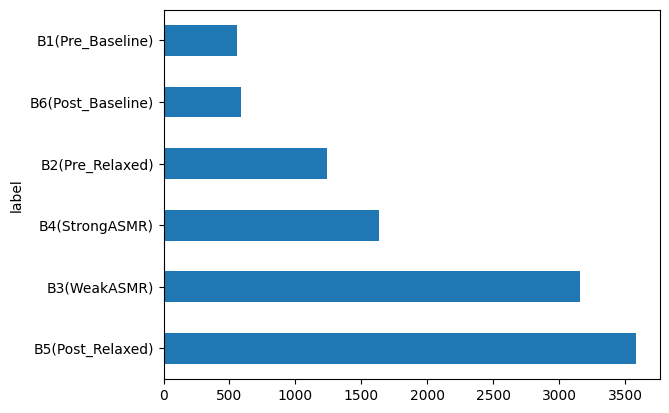

In [5]:
df['label'].value_counts().plot(kind='barh')
plt.show()

The class distribution in our dataset is unbalanced, necessitating careful selection of performance metrics to accurately assess our classifier.

Let's take a look at some of the segments.

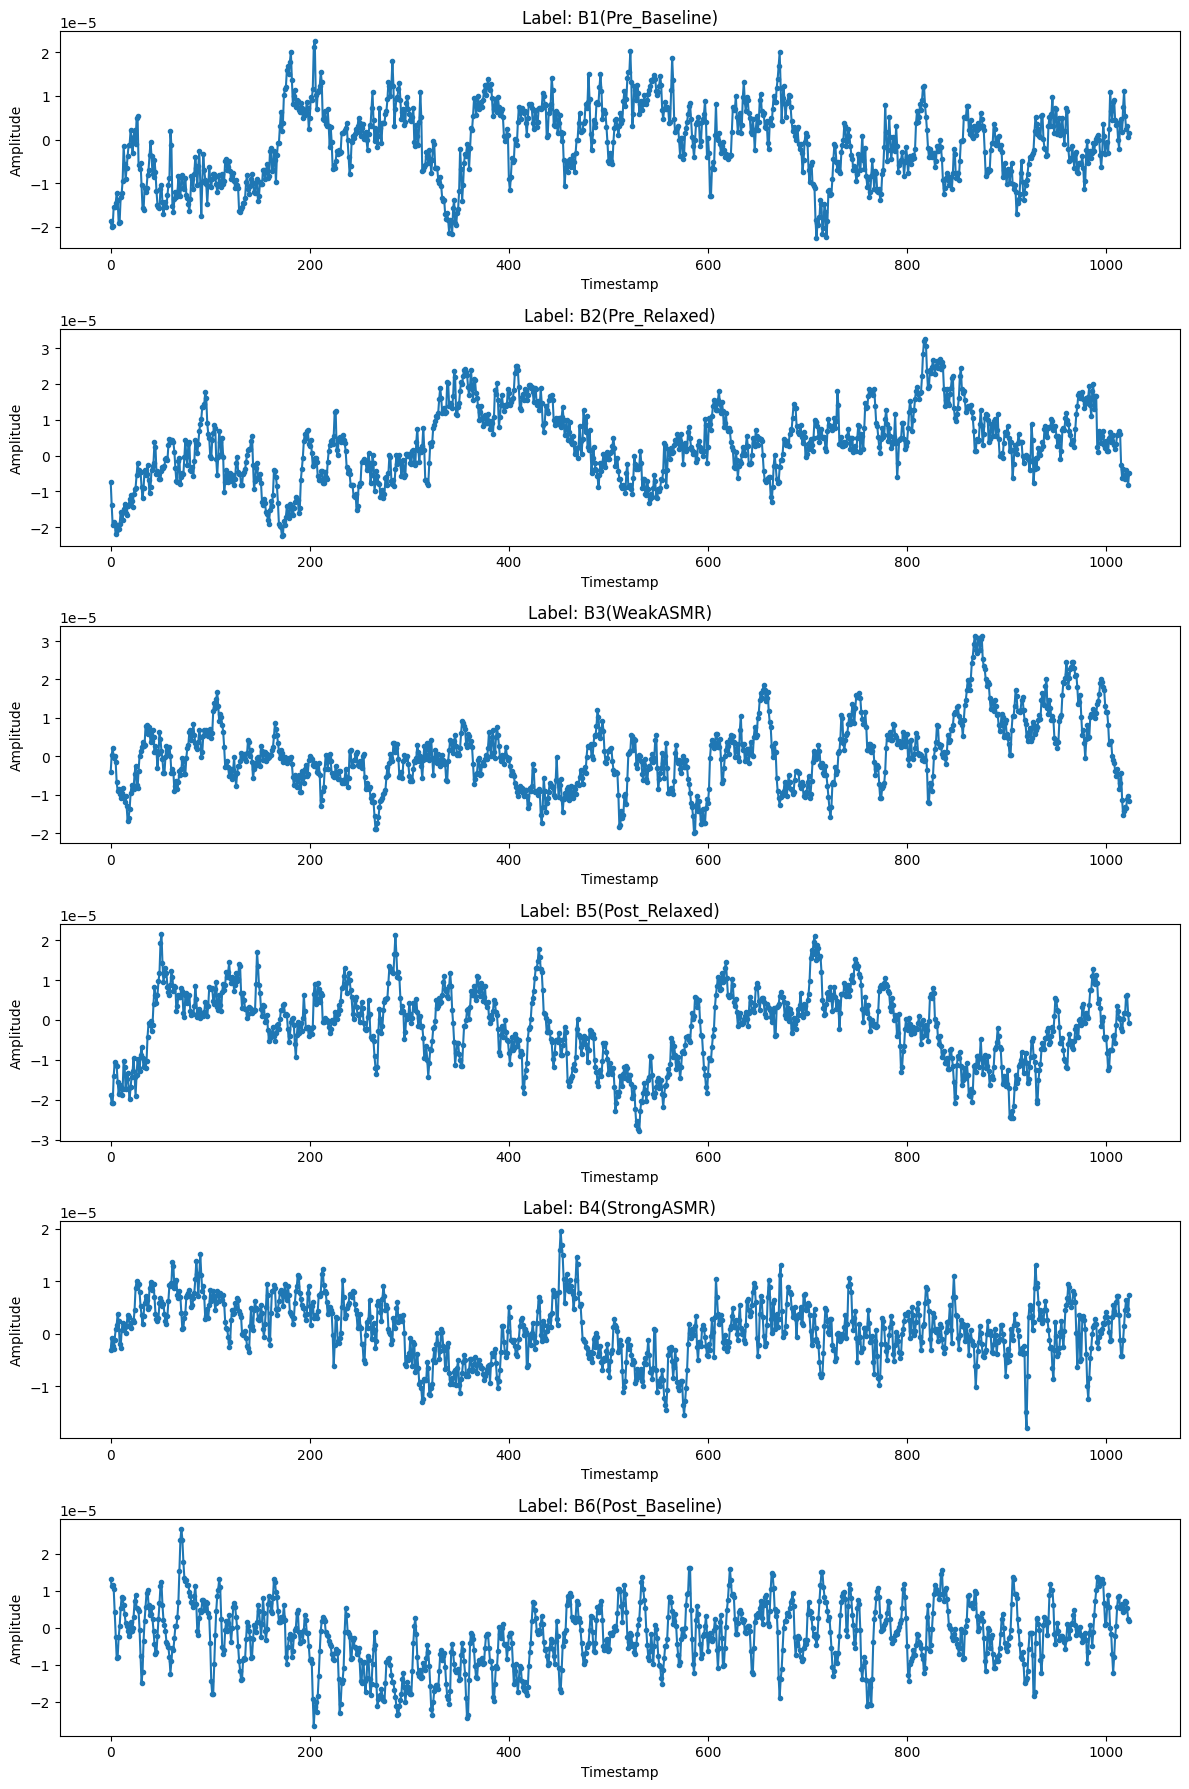

In [6]:
samples = df.groupby('label').head(1)

fig, axs = plt.subplots(nrows=len(samples), figsize=(12, len(samples) * 3))

for ax, (_, row) in zip(axs, samples.iterrows()):
    ax.plot(row['interval'][0, :], marker='.', linestyle='-') 
    ax.set_title(f"Label: {row['label']}")
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Amplitude')

plt.tight_layout()
plt.show()

Let's also look at the point clouds.

In [7]:
from gtda.plotting import plot_point_cloud


label = 'B1(Pre_Baseline)'
print(f'Label: {label}')
plot_point_cloud(df[df['label'] == label]['point_cloud'].iloc[0][0])

Label: B1(Pre_Baseline)


In [8]:
label = 'B4(StrongASMR)'
print(f'Label: {label}')
plot_point_cloud(df[df['label'] == label]['point_cloud'].iloc[0][0])

Label: B4(StrongASMR)


## 4. Topological feature extraction

In [9]:
from gtda.homology import VietorisRipsPersistence


VR = VietorisRipsPersistence(homology_dimensions=[0, 1, 2])

samples = df.groupby('label').head(1)

def plot_persistence_diagram(samples, idx):
    print(f"Label: {samples['label'].iloc[idx]}")
    _ = VR.fit_transform_plot(samples['point_cloud'].iloc[idx])

In [10]:
plot_persistence_diagram(samples, 0)

Label: B1(Pre_Baseline)


In [11]:
plot_persistence_diagram(samples, 4)

Label: B4(StrongASMR)


In [12]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from config import SEED


n_samples = 4

samples = df.groupby('label').sample(n=n_samples, random_state=SEED).reset_index(drop=True)

labels = sorted(df['label'].unique())

fig = make_subplots(rows=6, 
                    cols=n_samples, 
                    subplot_titles=[f'Label: {label}' for label in labels for _ in range(n_samples)], 
                    vertical_spacing=0.05)

row = 1
col = 1

for label in labels:
    for idx in range(n_samples):
        sample = samples[(samples['label'] == label)].iloc[idx]
        diagrams = VR.fit_transform(sample['point_cloud'])
        diagram = diagrams[0] # Only the first channel is used

        conditions = [
            diagram[:, 2] == 0,
            diagram[:, 2] == 1,
            diagram[:, 2] == 2
        ]
        choices = ['red', 'green', 'blue']
        colors = np.select(conditions, choices)

        trace = go.Scatter(x=diagram[:, 0], y=diagram[:, 1], mode='markers', marker=dict(color=colors))
        
        fig.add_trace(trace, row=row, col=col)
        
        if col < n_samples:
            col += 1
        else:
            col = 1
            row += 1

fig.update_xaxes(matches='x')
fig.update_yaxes(matches='y', scaleanchor='x', scaleratio=1)

fig.update_layout(height=1500, width=1000, title_text='Persistence Diagrams Grid', showlegend=False)
fig.show()

## 5. Classification

In [1]:
from data import get_training_data

df = get_training_data()

df

id         label  channel  ASMR      PE_0      PE_1      PE_2
0    069  B3(WeakASMR)        0  True  6.494380  4.694598  1.393568
1    069  B3(WeakASMR)        1  True  6.491429  4.696886  2.048949
2    069  B3(WeakASMR)        2  True  6.493088  4.493448  0.973038
3    069  B3(WeakASMR)        3  True  6.541680  4.611029  1.259047
4    069  B3(WeakASMR)        4  True  6.529521  4.341313  0.000000
..   ...           ...      ...   ...       ...       ...       ...
635  055  B3(WeakASMR)       59  True  6.529225  4.522975  1.975615
636  055  B3(WeakASMR)       60  True  6.531844  4.725531  2.339678
637  055  B3(WeakASMR)       61  True  6.501784  4.891163  2.528339
638  055  B3(WeakASMR)       62  True  6.555313  4.529447  2.073248
639  055  B3(WeakASMR)       63  True  6.530028  4.096243  1.639726

[640 rows x 7 columns]

In [2]:
from data import split_training_data

X_train, X_val, y_train, y_val = split_training_data(df)

X_train = X_train.drop(columns=['id'])
X_val = X_val.drop(columns=['id'])

y_train

# DATA LEAK!!! how to split the data correctly?

557      B4(StrongASMR)
496    B5(Post_Relaxed)
65     B1(Pre_Baseline)
338        B3(WeakASMR)
49         B3(WeakASMR)
             ...       
71     B1(Pre_Baseline)
106    B1(Pre_Baseline)
270        B3(WeakASMR)
435     B2(Pre_Relaxed)
102    B1(Pre_Baseline)
Name: label, Length: 576, dtype: object

In [33]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score
from config import SEED

from sklearn.linear_model import LogisticRegression

model = RandomForestClassifier(max_depth=5, random_state=SEED)
model.fit(X_train, y_train)

accuracy = model.score(X_val, y_val)
print(f'Accuracy: {accuracy}')

y_probs = model.predict_proba(X_val)
roc_auc = roc_auc_score(y_val, y_probs, multi_class='ovr')
print(f'Multi-class ROC-AUC: {roc_auc}')

Accuracy: 0.390625
Multi-class ROC-AUC: 0.6394346883887005


## 6. Experiments

### TODO:

try different embeddings 

try different features

try different classifiers

## 7. Locating brain regions

### TODO:

PCA/SVD/etc

find the most informative channels

visualize the locations of the corresponding sensors on the brain